In [35]:
# External libraries
## NN specifics 
from transformers import AutoModel, AutoTokenizer, GPT2LMHeadModel
import torch

## General utilities
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
from tqdm import tqdm
import numpy as np
import sympy as sp
import linecache
import json

## For setting up the local server
import threading
from flask import Flask, request, jsonify
from flask_cors import CORS, cross_origin

In [36]:
# IPython environment
import ipywidgets as widgets
from IPython.core.display import HTML, display, clear_output

C:\Users\Hugo\AppData\Local\Temp\ipykernel_13152\976570212.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display, clear_output
C:\Users\Hugo\AppData\Local\Temp\ipykernel_13152\976570212.py:3: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display, clear_output


In [37]:
# Domestic Imports
from model.vocabulary import Vocabulary
from model.equation_interpreter import Equation
from model.tokens import TOKEN_TYPE_ANSWERS, TOKEN_TYPE_EXPRESSIONS, Token

### Meta stuff

In [38]:
def sum2tokens(mathematica_sum):
    """
    Example:
        '{{}, {-2, -2, -10, -8, -9, -8, -10, -5, -6, -4}}\n' ---> ['#', '/', '-2', '-2', '-10', '-8', '-9', '-8', '-10', '-5', '-6', '-4']

    """
    LHS, RHS = mathematica_sum.split("}, {")
    LHS, RHS = LHS.lstrip("{"), RHS.rstrip("\n").rstrip("}")
    if len(LHS) == 0:
        LHS = ["#"]
    else:
        LHS = LHS.split(", ")
    RHS = RHS.split(", ")    
    return LHS + ["/"] + RHS
sum2tokens('{{}, {-2, -2, -10, -8, -9, -8, -10, -5, -6, -4}}\n')

['#', '/', '-2', '-2', '-10', '-8', '-9', '-8', '-10', '-5', '-6', '-4']

In [39]:
def answer2tokens(answer):
    """
    Example:
        '(571057069 - 57859200*Pi^2)/1365590016000\n' ---> [Token(TT_INTEGER), Token(TT_INTEGER), Token(TT_PI), Token(TT_INTEGER), Token(TT_POW), Token(TT_MULTIPLY), Token(TT_MINUS), Token(TT_INTEGER), Token(TT_DIVIDE)]
    """
    equation = Equation.makeEquationFromString(answer)
    equation.convertToPostfix()
    if equation.notation != "postfix": return None
    return [token.t_type for token in equation.tokenized_equation]
answer2tokens('(571057069 - 57859200*Pi^2)/1365590016000\n')

['TT_INTEGER',
 'TT_INTEGER',
 'TT_PI',
 'TT_INTEGER',
 'TT_POW',
 'TT_MULTIPLY',
 'TT_MINUS',
 'TT_INTEGER',
 'TT_DIVIDE']

In [40]:
data_sums_fp = "./data/random-expressions-partition-8-4-2023.txt"
data_answers_fp = "./data/random-answers-partition-8-4-2023.txt"

In [41]:
raw_dataset_size = sum(1 for _ in open(data_sums_fp))
raw_dataset_size

36917890

In [42]:
# Counts the number of equations a given token can be found in
token_freq = {token[3:]:0 for token in TOKEN_TYPE_ANSWERS + ["TT_ZETA", "TT_POLYGAMMA", "TT_ROOTSUM", "TT_ROOT"] if token not in ["TT_RATIONAL", "TT_LEFT_PARENTHESIS", "TT_RIGHT_PARENTHESIS", "TT_VARIABLE"]}

In [43]:
# #####################################################
# # Takes 2 hours to run, so run only once, use after #
# #####################################################
# sumdeg2numaborted = {}
# for line_number, (raw_equation, raw_sum) in tqdm(enumerate(zip(open(data_answers_fp), open(data_sums_fp))), total=raw_dataset_size):
#     if raw_equation == "$Aborted\n":
#         sum_deg = len(sum2tokens(raw_sum)) - 1 # -1 for the "/" 
#         if sum_deg in sumdeg2numaborted:
#             sumdeg2numaborted[sum_deg] += 1
#         else:
#             sumdeg2numaborted[sum_deg] = 1
#         continue
#     equation = Equation.makeEquationFromString(raw_equation)
#     if not equation.tokenized_equation:
#         if "Zeta" in raw_equation:
#             token_freq["ZETA"] += 1
#         if "PolyGamma" in raw_equation:
#             token_freq["POLYGAMMA"] += 1
#         if "RootSum" in raw_equation:
#             token_freq["ROOTSUM"] += 1
#         if "Root[" in raw_equation: # the "[" is to differentiate between Root[*] and the "Root" in RootSum
#             token_freq["ROOT"] += 1
#         continue
            
#     equation.convertToPostfix()
#     if equation.notation == "infix": continue

#     for token in equation.tokenized_equation:
#         token_freq[token.t_type[3:]] += 1

In [44]:
with open("./sumdeg2numaborted.json", "r") as f:
    sumdeg2numaborted = json.load(f)
f.close()
with open("./token_freq.json", "r") as f:
    token_freq = json.load(f)
f.close()

In [45]:
len(sumdeg2numaborted), len(token_freq)

(13, 22)

# Data Analysis

### Dataset Decisions
Abortion rate of given data plot

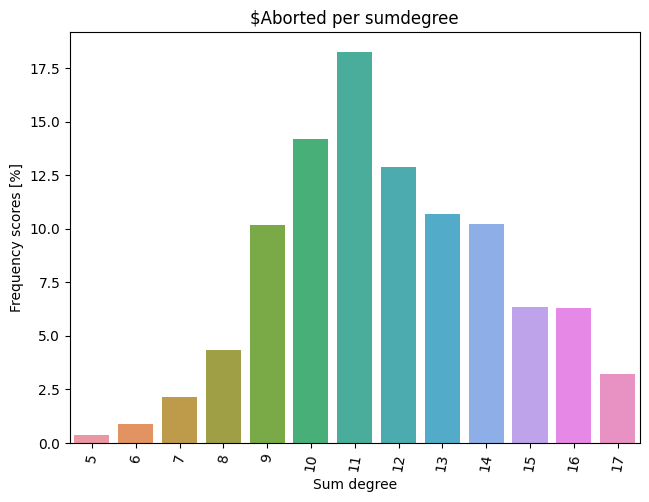

In [46]:
total_aborted = sum(sumdeg2numaborted.values())

plt.xticks(rotation=80)
plt.tight_layout()

ax = sns.barplot([[v*100/total_aborted] for _,v in sorted(sumdeg2numaborted.items(), key = lambda v: int(v[0]))])

ax.set_xticks(range(len(sumdeg2numaborted)))
ax.set_xticklabels(sorted([k for k,_ in sorted(sumdeg2numaborted.items(), key = lambda v: int(v[0]))], key=lambda v: int(v)), fontsize=10)
plt.title("$Aborted per sumdegree")
plt.ylabel("Frequency scores [%]")
plt.xlabel("Sum degree")
plt.show()

HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; }</style>") # To center the plot

### Token frequency
To get a good picture of the frequency differences, try turning off the most frequent tokens

In [66]:
token_freq

{'PI': 69095147,
 'E': 0,
 'PHI': 0,
 'CATALAN': 175129,
 'EULERGAMMA': 15542336,
 'INTEGER': 809657537,
 'ZERO': 23608289,
 'ONE': 3509987,
 'SQRT': 215904196,
 'SIN': 0,
 'COS': 0,
 'TAN': 0,
 'LOG': 106694869,
 'PLUS': 148947959,
 'MINUS': 175549958,
 'MULTIPLY': 338236488,
 'DIVIDE': 240009482,
 'POW': 512612,
 'ZETA': 94009,
 'POLYGAMMA': 2910400,
 'ROOTSUM': 2329045,
 'ROOT': 992}

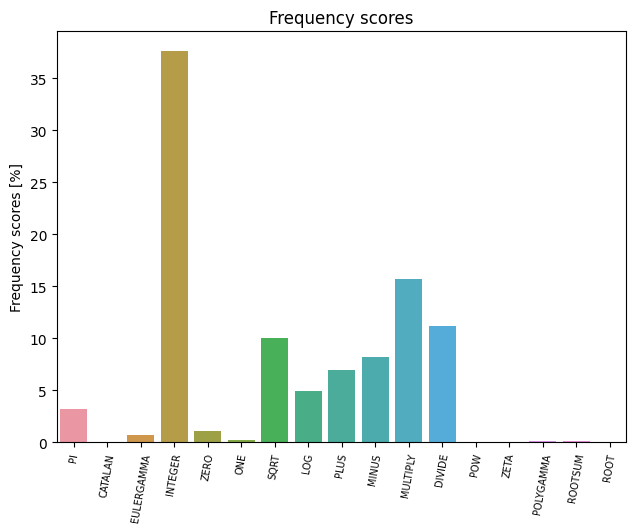

In [47]:
n = len(token_freq)
S = sum(token_freq.values())
initial_ban_list = {token for token,freq in token_freq.items() if freq == 0}
buttons = [widgets.Button(description=token, style={"button_color": ("red" if token in initial_ban_list else "#90ee90")}) for token in token_freq]

# Plotter function
def frequency_plotter():
    banned = set()
    for button in buttons:
        if button.style.button_color == "red": 
            banned.add("TT_" + button.description)

    plt.xticks(rotation=80)
    plt.tight_layout()

    ax = sns.barplot([[v*100/S] for t,v in token_freq.items() if "TT_" + t not in banned])

    ax.set_xticks(range(len(token_freq) - len(banned)))
    ax.set_xticklabels([token for token in token_freq.keys() if "TT_" + token not in banned], fontsize=7)
    plt.title("Frequency scores")
    plt.ylabel("Frequency scores [%]")
    plt.show()

# Function to change color when button is clicked
def on_button_click(button):
    if button.style.button_color == '#90ee90':
        button.style.button_color = 'red'
    else:
        button.style.button_color = '#90ee90'
    clear_output(wait=True)  # Clear the output of the cell
    display(widgets.VBox([widgets.HBox(buttons[:n//2]), widgets.HBox(buttons[n//2:])]))  # Redisplay the buttons
    frequency_plotter()  # Call the plotter function again

for button in buttons:
    button.on_click(on_button_click)

row1 = widgets.HBox(buttons[:n//2])
row2 = widgets.HBox(buttons[n//2:])
display(widgets.VBox([row1, row2]))
frequency_plotter()

# LLM

In [48]:
model_id = "Dragonoverlord3000/JustSumAI2"
# revision = "477033a6aee0b41770035aedfe86692e4f03b585" # Should be changed to a newer version

### Why not $\mathbb{Z}$?
To see that by far the majority of polynomials, of the form we're considering, will evaluate to $\frac{Z}{Z}$ or $\frac{Z}{Z} + \frac{Z}{Z}\pi^Z$, consider the following equality for both $a,b \in \mathbb{Q}$ and for $a,b \in \mathbb{Z}$ respectively:
\begin{equation}
\frac{n-a}{n-b} = 1 + \frac{b - a}{n - b}
\end{equation}
Clearly $\sum\limits_{n=1}^\infty \frac{1}{(n-a)(n-b)}$ is a rational number, when $a,b \in \mathbb{Z}$ and $a \neq b$ and also clearly when $a = b$ we get $\frac{Z}{Z}\pi^Z$. 

## Initial model - 2

## Initial model - 1

In [49]:
# model = AutoModel.from_pretrained(model_id, force_download=True)
# tokenizer = AutoTokenizer.from_pretrained(model_id, force_download=True)
# print(model, tokenizer)
# encoded_test = tokenizer.encode("# / -1/5 0 [SEP] TT_INTEGER")
# decoded_test = tokenizer.decode(encoded_test)
# print(encoded_test, decoded_test)
# print(tokenizer.get_vocab())
# from transformers import pipeline

# generation = pipeline("text-generation", model=model_id)
# generation("# / 0 0 [SEP]")

In [50]:
model = GPT2LMHeadModel.from_pretrained(f"Dragonoverlord3000/JustSumAI", force_download=True, revision="6512ca7619eafd2da815379268c73c4382b8d3a1")
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(68, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=68, bias=False)
)

In [51]:
vocabulary = Vocabulary.construct_from_list(TOKEN_TYPE_EXPRESSIONS + TOKEN_TYPE_ANSWERS)
def predict(input_sum: List[str]):
    """
    Args:
        input_sum: e.g. ["#", "/", "-1", "0"]
    """
    input_sum = torch.LongTensor([vocabulary.vectorize(input_sum)[:-1] + [vocabulary.separator_index]])
    out = model.generate(input_sum,
                        eos_token_id=vocabulary.end_seq_index, 
                        pad_token_id=vocabulary.mask_index)
    pred = [vocabulary.getToken(o.item()) for o in out[0]]
    return pred
pred = predict(["#", "/", "-1", "0"])
pred

C:\Users\Hugo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (227) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['<BEGIN>',
 '#',
 '/',
 '-1',
 '0',
 '[SEP]',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_SQRT',
 'TT_MULTIPLY',
 'TT_PI',
 'TT_MULTIPLY',
 'TT_PLUS',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_LOG',
 'TT_MULTIPLY',
 'TT_MINUS',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_DIVIDE',
 '<END>']

In [52]:
eq = Equation([Token(t) for t in pred[pred.index("[SEP]")+1:-4]], notation="postfix")
eq.getMathmetaicalNotation()

'((Z+((Z*Sqrt(Z))*Pi))-(Z*Log(Z)))'

### Trying the model

In [53]:
# Setup local server
def run_flask_app():
    app = Flask(__name__)
    CORS(app)  # This will enable CORS for all routes

    @app.route("/")
    def home():
        return "<h1>YOYO</h1>"

    @app.route("/calculate", methods=["POST"])
    def calculate():
        data = request.get_json()
        input_sum = (["#"] if not data["numerator_list"] else data["numerator_list"]) + ["/"] + data["denominator_list"]
        prediction = predict(input_sum)
        print(prediction)
        try:
            eq = Equation([Token(t) for t in pred[pred.index("[SEP]")+1:]], notation="postfix")
            eq.convertToInfix()
            print(eq.tokenized_equation)
            result = "<mo>=</mo>" + sp.mathml(sp.parse_expr(eq.getMathmetaicalNotation(), evaluate=False))
            print(result)
    #         result = "<mo>=</mo><msup><mi>Z</mi><mn>2</mn></msup><mo>+</mo><mi>π</mi><mo>*</mo><mn>2</mn>"
        except:
            result = "<mo>=</mo><mi>:</mi><mo>(</mo>"
        return jsonify({'result': result})

    app.run(debug=True, port=6283, use_reloader=False)

# Run the Flask app in a new thread
flask_thread = threading.Thread(target=run_flask_app)
flask_thread.start()

 * Serving Flask app '__main__'
 * Debug mode: on


In [54]:
def build_root(id:str):
    return f"""      
    <mo>(</mo>
    <mi>n</mi>
    <mo>-</mo>
    <mn onclick='var numField = document.getElementById("{id}"); numField.innerHTML = parseInt({id}.innerHTML) + 1 == 5 ?  -5 : parseInt({id}.innerHTML) + 1;' id='{id}'>1</mn>
    <mo>)</mo>
    """

In [55]:
def build_roots(num, offset=0):
    if num == 0: return "<mn>1</mn>"
    
    out = ""
    for root_num in range(num):
        out += build_root(f"Root_{root_num+offset}")
    return out

 * Running on http://127.0.0.1:6283
Press CTRL+C to quit

In [56]:
# Initialize the numerator and denominator
num_denominator = 0
num_numerator = 0

In [57]:
# create an HTML widget to show a paragraph
HTML_text = """<center><h1>AI - Calculator</h1></center><div style='display: flex; align-items: center; justify-content: center;'>
<button style="
background-color: #2b2b2b; border: none; color: white; padding: 5px 10px; text-align: center; text-decoration: none; display: inline-block; font-size: 12px; margin: 2px 15px 2px 0px; cursor: pointer; -webkit-transition-duration: 0.4s; transition-duration: 0.4s; border-radius: 5px; border: 1px solid #f9f9f9;
" 
  onclick="fetch('http://localhost:6283/calculate', { method: 'POST', headers: {'Accept': 'application/json', 'Content-Type': 'application/json'}, body: JSON.stringify({""" + f"numerator_list: [{','.join([f'document.getElementById(`Root_{i}`).innerHTML' for i in range(num_numerator)])}], denominator_list: [{','.join([f'document.getElementById(`Root_{i}`).innerHTML' for i in range(num_numerator, num_numerator+num_denominator)])}]" + """}) })
            .then(response => response.json())
            .then(json => {console.log(json); document.getElementById('result').innerHTML = json.result;})">
  Calculate
</button>""" + \
f"""<math xmlns="http://www.w3.org/1998/Math/MathML" display="block" style='color: black; font-size: 22px' id='LHS'>
  <munderover>
    <mo>&#x2211;</mo>  <!-- SUM SYMBOL -->
    <mrow>
      <mi>i</mi>  <!-- INDEX VARIABLE -->
      <mo>=</mo>
      <mn>1</mn>  <!-- LOWER BOUND -->
    </mrow>
    <mrow>
      <mo>&#x221E;</mo>  <!-- UPPER BOUND -->
    </mrow>
  </munderover>
  <mfrac>
    <mrow>
      {build_roots(num_numerator)}
    </mrow>
    <mrow>
      {build_roots(num_denominator, offset=num_numerator)}
    </mrow>
  </mfrac>
  <mrow id="result">
  </mrow>
</math>
</div>
"""

html = widgets.HTML(
    value=HTML_text,
    placeholder='Some HTML',
)

# Set the numerator and denominator degrees
def set_degrees(*args):
    global num_numerator, num_denominator
    num_numerator = num_numerator_slider.value
    num_denominator = num_denominator_slider.value
    HTML_text = """<center><h1>AI - Calculator</h1></center><div style='display: flex; align-items: center; justify-content: center;'>
    <button style="
    background-color: #2b2b2b; border: none; color: white; padding: 5px 10px; text-align: center; text-decoration: none; display: inline-block; font-size: 12px; margin: 2px 15px 2px 0px; cursor: pointer; -webkit-transition-duration: 0.4s; transition-duration: 0.4s; border-radius: 5px; border: 1px solid #f9f9f9;
    " 
      onclick="fetch('http://localhost:6283/calculate', { method: 'POST', headers: {'Accept': 'application/json', 'Content-Type': 'application/json'}, body: JSON.stringify({""" + f"numerator_list: [{','.join([f'document.getElementById(`Root_{i}`).innerHTML' for i in range(num_numerator)])}], denominator_list: [{','.join([f'document.getElementById(`Root_{i}`).innerHTML' for i in range(num_numerator, num_numerator+num_denominator)])}]" + """}) })
                .then(response => response.json())
                .then(json => {console.log(json); document.getElementById('result').innerHTML = json.result;})">
      Calculate
    </button>""" + \
    f"""<math xmlns="http://www.w3.org/1998/Math/MathML" display="block" style='color: black; font-size: 22px' id='LHS'>
      <munderover>
        <mo>&#x2211;</mo>  <!-- SUM SYMBOL -->
        <mrow>
          <mi>i</mi>  <!-- INDEX VARIABLE -->
          <mo>=</mo>
          <mn>1</mn>  <!-- LOWER BOUND -->
        </mrow>
        <mrow>
          <mo>&#x221E;</mo>  <!-- UPPER BOUND -->
        </mrow>
      </munderover>
      <mfrac>
        <mrow>
          {build_roots(num_numerator)}
        </mrow>
        <mrow>
          {build_roots(num_denominator, offset=num_numerator)}
        </mrow>
      </mfrac>
      <mrow id="result">
      </mrow>
    </math>
    </div>
    """

    html = widgets.HTML(
        value=HTML_text,
        placeholder='Some HTML',
    )
    clear_output()
    display(widgets.HBox([num_numerator_slider, num_denominator_slider]), html)
    

num_numerator_slider = widgets.IntSlider(value=num_numerator, min=0, max=10, step=1, description='Numerator Degree:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d', style={'description_width': 'initial'})
num_denominator_slider = widgets.IntSlider(value=num_denominator, min=0, max=10, step=1, description='Denominator Degree:', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d', style={'description_width': 'initial'})

num_numerator_slider.observe(set_degrees)
num_denominator_slider.observe(set_degrees)

display(widgets.HBox([num_numerator_slider, num_denominator_slider]), html)

HTML(value='<center><h1>AI - Calculator</h1></center><div style=\'display: flex; align-items: center; justify-…

### Validation
`root_pred` is the root of the predicted tree

`root_correct` is the root of the correct tree

Does a simultaneous BFS and each time a discrepancy is encountered, every tool in the arsenal above is thrown at it (not actually, only the result - like for lehvenstein), and the action used is recorded so the result also provides what operations are needed where


An important note is that because of the `Replace and Swap` operator TED(a,b) is not necessarily TED(b,a), based on the commutativity of the replacement operator

In [58]:
from TED import get_steps, TreeEditDistance, show_graph, graph_from_postfix

In [59]:
test_cases = []

In [60]:
_, predicted_graph = graph_from_postfix([Token(t) for t in ["TT_INTEGER", "TT_INTEGER", "TT_DIVIDE"]])
_, correct_graph = graph_from_postfix([Token(t) for t in ["TT_INTEGER", "TT_LOG", "TT_LOG", "TT_SQRT"]])
predicted_graph, correct_graph

([TT_DIVIDE | Left: [TT_INTEGER | Left: None | Right: None | Parent: TT_DIVIDE] | Right: [TT_INTEGER | Left: None | Right: None | Parent: TT_DIVIDE] | Parent: None],
 [TT_SQRT | Left: None | Right: [TT_LOG | Left: None | Right: [TT_LOG | Left: None | Right: [TT_INTEGER | Left: None | Right: None | Parent: TT_LOG] | Parent: TT_LOG] | Parent: TT_SQRT] | Parent: None])

In [61]:
steps = get_steps(predicted_graph, correct_graph)
steps[1][1]

(1, '/', '\\sqrt{\\;}')

In [62]:
def my_formatter(expr):
    expr = expr.replace("{", "(x").replace("}", ")")
    expr = expr.replace(r"\;", "").replace("\\", "").replace(";", "")
    expr = expr.replace("log", "log(x)")
    return expr

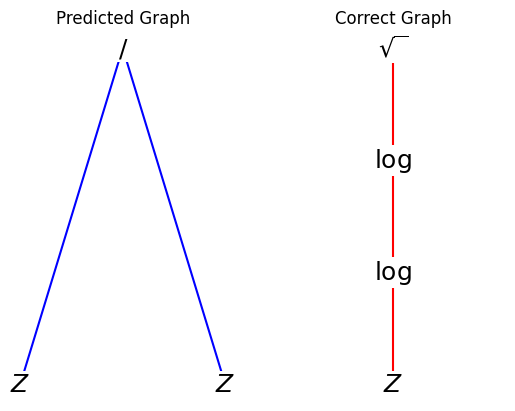

In [63]:
plt.subplot(1,2,1)
plt.title("Predicted Graph")
show_graph(predicted_graph, color="blue")
plt.subplot(1,2,2)
plt.title("Correct Graph")
show_graph(correct_graph, color="red")
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [64]:
# Initialize output widget
out = widgets.Output()

# Initialize a counter
counter = 0


# Initialize the buttons
next_button = widgets.Button(description='Next')
prev_button = widgets.Button(description='Previous')

# Plot the graphs
def plot_graphs(counter):
    plt.subplot(1,2,1)
    show_graph(steps[counter][0], color="blue" if counter == 0 else "orange")
    plt.subplot(1,2,2)
    show_graph(steps[counter+1][0], color="red" if counter+1 == len(steps)-1 else "orange")
    if steps[counter+1][1] and steps[counter+1][1][2]:
        plt.suptitle(f"${steps[counter+1][1][2]}$", fontsize=14)
    plt.show()

# Define the button click actions
def next_button_clicked(b):
    global counter
    counter = min(len(steps)-2, counter+1)
    out.clear_output()
    with out:
        plot_graphs(counter)

def prev_button_clicked(b):
    global counter
    counter = max(0, counter-1)
    out.clear_output()
    with out:
        plot_graphs(counter)

# Assign the actions to the button on click
next_button.on_click(next_button_clicked)
prev_button.on_click(prev_button_clicked)

# Create a horizontal box with the buttons
button_box = widgets.HBox([prev_button, next_button])

# Display the buttons and the output
display(button_box, out)

# Display the initial graphs
with out:
    plot_graphs(counter)

Output()

## Fine-tuned model

### Validation

# Tests